## Pandas API and decorators
This library is created for practicing decorators and libraries through Pandas API

In [1]:
import oop
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

A random message

THIS IS A TEST

My arguments are: Nairobi, Accra
Cities I love are Nairobi and Accra

The wrapper can access all the variables
	- from the decorator maker: Pandas Numpy Scikit-learn
	- from the function call: Pandas Science Tools
and pass them to the decorated function
This is the decorated function and it only knows about its arguments: Pandas Science Tools



In [2]:
try:
    del pd.DataFrame.missing
except AttributeError:
    pass

In [3]:
@pd.api.extensions.register_dataframe_accessor('missing')
class MissingMethods:
    def __init__(self, pandas_obj):
        self._df = pandas_obj
    
    def number_missing(self) -> int:
        """Accounts for all missing values 'NaN' type within dataset"""
        return self._df.isna().sum().sum()
    
    def number_complete(self) -> int:
        """Accounts for complete values"""
        return self._df.size - self._df.missing.number_missing()
    
    def missing_variable_summary(self) -> pd.DataFrame:
        """Return a table with all missing values per variable, columns in the dataframe"""
        return self._df.isnull().pipe(
            lambda null_df:(
                null_df.sum() #Return the sum of the values over the requested axis, where null values are present.
                .reset_index(name="n_missing")
                .rename(columns={"index":"variable"})
                .assign( #create two new columns
                    n_cases = len(null_df),
                    percent_missing = lambda df_2 : df_2.n_missing / df_2.n_cases * 100, #Calculates % of missing cases
                )
            )
        )
    
    def missing_case_summary(self) -> pd.DataFrame:
        """ Accounts missing values per case, rows in the dataframe. n_missing corresponds to
            a sum of all null values present in each row.
        """
        return self._df.assign(
            case = lambda df: df.index,
            n_missing = lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            percent_missing = lambda df: df.n_missing / df.shape[1] * 100
        )[['case', 'n_missing', 'percent_missing']]
            
    def missing_variable_table(self) -> pd.DataFrame:
        """ Takes out the n_missing values from missing_variable_summary, and calculates a percent of n_missing values
            respect to total missing values for variables."""
        return (
            self._df.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={'n_missing': 'n_missing_in_variable', 0:'n_variables'})
            .assign(
                percent_variables = lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values('percent_variables', ascending=False)
        )
    
    def missing_case_table(self) -> pd.DataFrame:
        """ Takes out the n_missing values from missing_case_summary, and calculates a percent of n_missing values
            respect to total missing values for cases. """
        return (
            self._df.missing.missing_case_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={'n_missing': 'n_missing_in_case', 0:'n_cases'})
            .assign(
                percent_variables = lambda df: df.n_cases / df.n_cases.sum() * 100
            )
            .sort_values('percent_variables', ascending=False)
        )
        
    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        return (
            self._df.assign(
                span_counter = lambda df:(
                    np.repeat(a=range(df.shape[0]), repeats=span_every)[: df.shape[0]]
                )
                
            )
            .groupby('span_counter')
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )
        
    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )
        
    def missing_variable_plot(self):
        """Graphic representation of missing variable summary."""
        df = self._df.missing.missing_variable_summary().sort_values('n_missing')
        plot_range = range(1, len(df.index) + 1)
        plt.plot(df.n_missing, plot_range, 'o', color='black')
        plt.hlines(y = plot_range, xmin = 0, xmax = df.n_missing, color = 'black')
        plt.xlabel('Number missing')
        plt.ylabel('Variable')
        plt.yticks(plot_range, df.variable)
        plt.grid(axis="y")
        plt.show()
        
    def missing_case_plot(self):
        """Graphic representation of missing case summary"""
        df = self._df.missing.missing_case_table()
        sns.barplot(data = df, x = 'n_missing_in_case', y = 'n_cases', color = 'black')
        # plt.grid(axis='x')
        plt.xlabel("Number of missings in case")
        plt.ylabel("Number of cases")
        

In [4]:
df = pd.read_csv(
    './../data/raw/pima-indians-diabetes.csv',
    sep=',',
    names=[
        "pregnancies",
        "glucose",
        "blood_pressure",
        "skin_thickness",
        "insulin",
        "bmi",
        "diabetes_pedigree_function",
        "age",
        "outcome",
    ]
    )
df

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
df[df.columns[1:6]] = df[df.columns[1:6]].replace(0, np.nan)

In [6]:
df.missing.number_missing()

652

In [7]:
df.missing.number_complete()

6260

In [8]:
variable_summary = df.missing.missing_variable_summary().sort_values('n_missing', ascending=True)
variable_summary

,variable,n_missing,n_cases,percent_missing
0,pregnancies,0,768,0.000000
6,diabetes_pedigree_function,0,768,0.000000
7,age,0,768,0.000000
8,outcome,0,768,0.000000
1,glucose,5,768,0.651042
5,bmi,11,768,1.432292
2,blood_pressure,35,768,4.557292
3,skin_thickness,227,768,29.557292
4,insulin,374,768,48.697917


In [9]:
df.missing.missing_case_summary()

,case,n_missing,percent_missing
0,0,1,9.090909
1,1,1,9.090909
2,2,2,18.181818
3,3,0,0.000000
4,4,0,0.000000
...,...,...,...
763,763,0,0.000000
764,764,1,9.090909
765,765,0,0.000000
766,766,2,18.181818


In [10]:
df.missing.missing_variable_table()

,n_missing_in_variable,n_variables,percent_variables
0,0,4,44.444444
1,5,1,11.111111
2,11,1,11.111111
3,35,1,11.111111
4,227,1,11.111111
5,374,1,11.111111


In the above table, we can find out information that answers *how many variables has a X number of missing values*. In this case, 4 of them does not present `nan`, 3 variables present between 5 and 35, and 2 variables present more than 227 missing values.

In [11]:
df.missing.missing_case_summary()

,case,n_missing,percent_missing
0,0,1,9.090909
1,1,1,9.090909
2,2,2,18.181818
3,3,0,0.000000
4,4,0,0.000000
...,...,...,...
763,763,0,0.000000
764,764,1,9.090909
765,765,0,0.000000
766,766,2,18.181818


In [12]:
df.missing.missing_case_table()

,n_missing_in_case,n_cases,percent_variables
0,0,392,51.041667
1,2,199,25.911458
2,1,142,18.489583
3,3,28,3.645833
4,4,7,0.911458


In [13]:
df.missing.missing_variable_span(variable='blood_pressure', span_every=100)

,span_counter,n_missing,n_complete,pct_missing,pct_complete
0,0,6,94,6.000000,94.000000
1,1,2,98,2.000000,98.000000
2,2,4,96,4.000000,96.000000
3,3,5,95,5.000000,95.000000
4,4,7,93,7.000000,93.000000
5,5,4,96,4.000000,96.000000
6,6,5,95,5.000000,95.000000
7,7,2,66,2.941176,97.058824


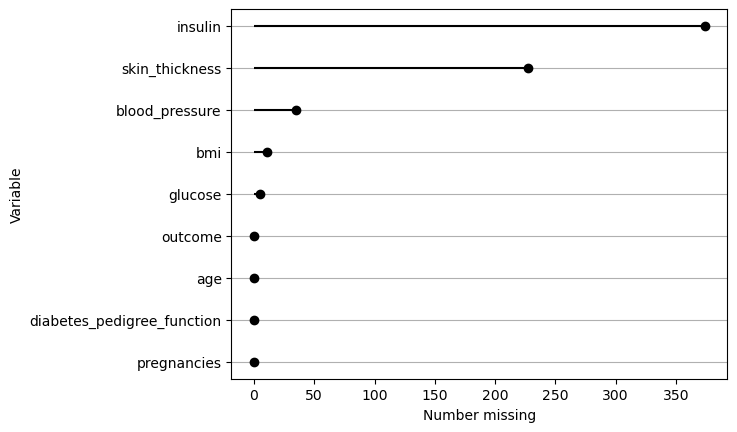

In [14]:
df.missing.missing_variable_plot()

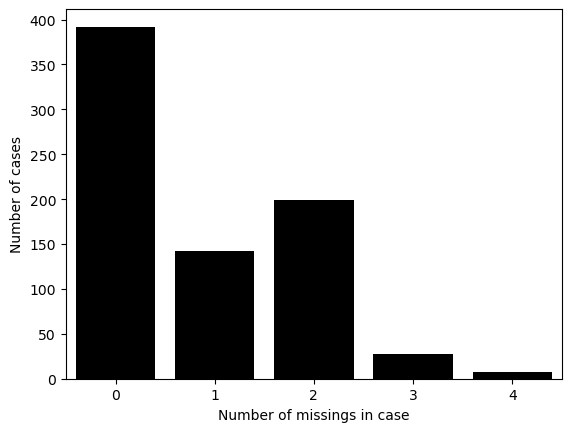

In [15]:
df.missing.missing_case_plot()
